<a href="https://colab.research.google.com/github/KalraAkshay/surge_price_prediction/blob/main/surge_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders
!pip install catboost

     |████████████████████████████████| 80 kB 4.7 MB/s 
     |████████████████████████████████| 67.4 MB 27 kB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

%cd drive/My\ Drive/assessment_data

Mounted at /content/drive
/content/drive/My Drive/assessment_data


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statistics import mode
import warnings
warnings.filterwarnings('ignore')
np.random.seed(0)

In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
len(train_df), len(test_df)

(131662, 87395)

In [6]:
%cd ..
%cd ..
%cd ..
%cd ..

/content/drive/My Drive
/content/drive
/content
/


In [7]:
train_df.head()

,Trip_ID,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
0,T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
1,T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
2,T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
3,T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
4,T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


In [8]:
train_df.isna().sum()

Trip_ID                            0
Trip_Distance                      0
Type_of_Cab                    20210
Customer_Since_Months           5920
Life_Style_Index               20193
Confidence_Life_Style_Index    20193
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           71030
Var2                               0
Var3                               0
Gender                             0
Surge_Pricing_Type                 0
dtype: int64

In [9]:
test_df.isna().sum()

Trip_ID                            0
Trip_Distance                      0
Type_of_Cab                    13158
Customer_Since_Months           3966
Life_Style_Index               13327
Confidence_Life_Style_Index    13327
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           46789
Var2                               0
Var3                               0
Gender                             0
dtype: int64

In [10]:
train_df['Surge_Pricing_Type'].value_counts()

2    56728
3    47720
1    27214
Name: Surge_Pricing_Type, dtype: int64

In [12]:
cat_cols = ['Type_of_Cab', 'Confidence_Life_Style_Index', 'Destination_Type', 'Gender']
con_cols = ['Life_Style_Index', 'Var1', 'Customer_Since_Months']

In [13]:
Y = train_df['Surge_Pricing_Type'].values
ids = test_df['Trip_ID']
train_df = train_df.drop(['Surge_Pricing_Type'], axis=1)

In [14]:
train_size = len(train_df)
df = pd.concat([train_df, test_df],axis=0)
df = df.drop(['Trip_ID'], axis=1)
cols = list(df.columns.values)
df.head(3)

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender
0,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female
1,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male
2,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male


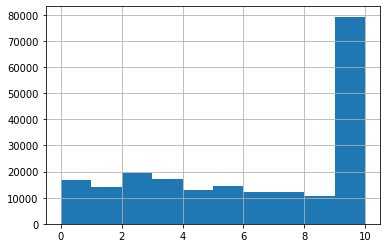

In [15]:
df['Customer_Since_Months'].hist(bins=10)

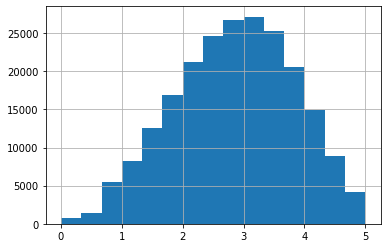

In [16]:
df['Customer_Rating'].hist(bins=15)

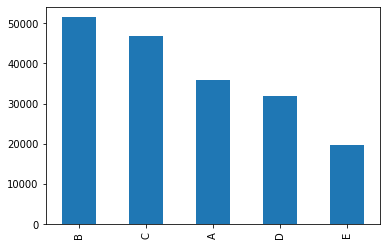

In [17]:
df['Type_of_Cab'].value_counts().plot(kind='bar')

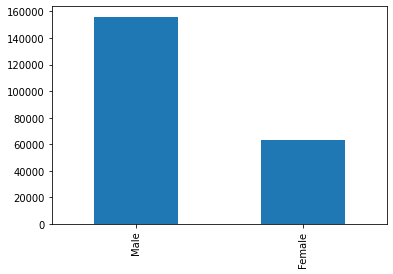

In [18]:
df['Gender'].value_counts().plot(kind='bar')

In [19]:
ce_bin = ce.OrdinalEncoder(cols=cat_cols)
df = ce_bin.fit_transform(df)

In [20]:
imputer = IterativeImputer(max_iter=100, initial_strategy='most_frequent', random_state=0)
new_df = imputer.fit_transform(df)
j = 0 
for i in list(df.columns.values):
  df[i] = new_df[:,j]
  j += 1

df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender
0,6.77,1.0,1.0,2.427690,1.0,1.0,3.90500,0.0,40.000000,46.0,60.0,1.0
1,29.47,1.0,10.0,2.782450,2.0,1.0,3.45000,0.0,38.000000,56.0,78.0,2.0
2,41.58,2.0,10.0,2.891258,3.0,2.0,3.50125,2.0,63.929325,56.0,77.0,2.0
3,61.56,3.0,10.0,2.920396,3.0,1.0,3.45375,0.0,63.313321,52.0,74.0,2.0
4,54.95,3.0,10.0,3.034530,2.0,1.0,3.40250,4.0,51.000000,49.0,102.0,2.0


In [21]:
ce_bin = ce.OneHotEncoder(cols=cat_cols)
df = ce_bin.fit_transform(df)
df.head()

,Trip_Distance,Type_of_Cab_1,Type_of_Cab_2,Type_of_Cab_3,Type_of_Cab_4,Type_of_Cab_5,Type_of_Cab_6,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index_1,Confidence_Life_Style_Index_2,Confidence_Life_Style_Index_3,Confidence_Life_Style_Index_4,Destination_Type_1,Destination_Type_2,Destination_Type_3,Destination_Type_4,Destination_Type_5,Destination_Type_6,Destination_Type_7,Destination_Type_8,Destination_Type_9,Destination_Type_10,Destination_Type_11,Destination_Type_12,Destination_Type_13,Destination_Type_14,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender_1,Gender_2
0,6.77,1,0,0,0,0,0,1.0,2.427690,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.90500,0.0,40.000000,46.0,60.0,1,0
1,29.47,1,0,0,0,0,0,10.0,2.782450,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.45000,0.0,38.000000,56.0,78.0,0,1
2,41.58,0,1,0,0,0,0,10.0,2.891258,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3.50125,2.0,63.929325,56.0,77.0,0,1
3,61.56,0,0,1,0,0,0,10.0,2.920396,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.45375,0.0,63.313321,52.0,74.0,0,1
4,54.95,0,0,1,0,0,0,10.0,3.034530,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3.40250,4.0,51.000000,49.0,102.0,0,1


In [22]:
df=((df-df.min())/(df.std()))
df.head(3)

,Trip_Distance,Type_of_Cab_1,Type_of_Cab_2,Type_of_Cab_3,Type_of_Cab_4,Type_of_Cab_5,Type_of_Cab_6,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index_1,Confidence_Life_Style_Index_2,Confidence_Life_Style_Index_3,Confidence_Life_Style_Index_4,Destination_Type_1,Destination_Type_2,Destination_Type_3,Destination_Type_4,Destination_Type_5,Destination_Type_6,Destination_Type_7,Destination_Type_8,Destination_Type_9,Destination_Type_10,Destination_Type_11,Destination_Type_12,Destination_Type_13,Destination_Type_14,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender_1,Gender_2
0,0.253260,2.356803,0.000000,0.0,0.0,0.0,0.0,0.281824,5.142539,2.259845,0.000000,0.000000,0.0,2.032403,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.978952,0.000000,0.670589,1.206152,0.690840,2.20999,0.00000
1,1.143199,2.356803,0.000000,0.0,0.0,0.0,0.0,2.818236,6.786350,0.000000,2.167889,0.000000,0.0,2.032403,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.515186,0.000000,0.536472,3.216406,2.245229,0.00000,2.20999
2,1.617964,0.000000,2.782902,0.0,0.0,0.0,0.0,2.818236,7.290523,0.000000,0.000000,2.777723,0.0,0.000000,7.012557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.567424,1.930047,2.275265,3.216406,2.158874,0.00000,2.20999


In [23]:
train_df = df[:train_size].copy()
test_df = df[train_size:].copy()

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
X_train, X_test, y_train, y_test = train_test_split(train_df, Y,test_size=0.2, random_state=0, stratify=Y)
X_train.shape, X_test.shape

((105329, 34), (26333, 34))

In [25]:
from sklearn.linear_model import LogisticRegression as LR
lr = LR(max_iter=500, class_weight={1:1,2:1,3:1})
lr.fit(X_train, y_train)
print(acc(y_test,lr.predict(X_test)))

0.6917176166786921


In [26]:
from catboost import CatBoostClassifier
cat = CatBoostClassifier(iterations=800, custom_metric=['Accuracy'])
cat.fit(X_train, y_train, eval_set=(X_test,y_test), use_best_model=True)
print(acc(y_test,cat.predict(X_test)))

Learning rate set to 0.129062
0:	learn: 1.0193935	test: 1.0196616	best: 1.0196616 (0)	total: 280ms	remaining: 3m 43s
1:	learn: 0.9638833	test: 0.9645726	best: 0.9645726 (1)	total: 516ms	remaining: 3m 25s
2:	learn: 0.9205758	test: 0.9213636	best: 0.9213636 (2)	total: 677ms	remaining: 2m 59s
3:	learn: 0.8877533	test: 0.8890292	best: 0.8890292 (3)	total: 838ms	remaining: 2m 46s
4:	learn: 0.8610320	test: 0.8624656	best: 0.8624656 (4)	total: 986ms	remaining: 2m 36s
5:	learn: 0.8389860	test: 0.8403366	best: 0.8403366 (5)	total: 1.15s	remaining: 2m 31s
6:	learn: 0.8222775	test: 0.8238736	best: 0.8238736 (6)	total: 1.3s	remaining: 2m 27s
7:	learn: 0.8088614	test: 0.8106168	best: 0.8106168 (7)	total: 1.59s	remaining: 2m 37s
8:	learn: 0.7966963	test: 0.7984387	best: 0.7984387 (8)	total: 1.78s	remaining: 2m 36s
9:	learn: 0.7869602	test: 0.7889307	best: 0.7889307 (9)	total: 1.93s	remaining: 2m 32s
10:	learn: 0.7789390	test: 0.7807667	best: 0.7807667 (10)	total: 2.11s	remaining: 2m 31s
11:	learn: 0

In [28]:
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=750, max_depth=4, seed=0, verbose=100)
xgb.fit(X_train,y_train, early_stopping_rounds=50, eval_metric="mlogloss",eval_set=[(X_train, y_train), (X_test, y_test)])
print(acc(y_test,xgb.predict(X_test)))

[0]	validation_0-mlogloss:1.05103	validation_1-mlogloss:1.05104
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 50 rounds.
[1]	validation_0-mlogloss:1.01052	validation_1-mlogloss:1.01107
[2]	validation_0-mlogloss:0.976451	validation_1-mlogloss:0.977212
[3]	validation_0-mlogloss:0.947494	validation_1-mlogloss:0.948227
[4]	validation_0-mlogloss:0.922358	validation_1-mlogloss:0.923316
[5]	validation_0-mlogloss:0.900778	validation_1-mlogloss:0.901821
[6]	validation_0-mlogloss:0.881948	validation_1-mlogloss:0.883112
[7]	validation_0-mlogloss:0.865645	validation_1-mlogloss:0.866983
[8]	validation_0-mlogloss:0.851463	validation_1-mlogloss:0.852884
[9]	validation_0-mlogloss:0.838951	validation_1-mlogloss:0.840493
[10]	validation_0-mlogloss:0.827964	validation_1-mlogloss:0.829733
[11]	validation_0-mlogloss:0.818251	validation_1-mlogloss:0.820173
[12]	validation_0-mlogloss:0.809684	validat

In [29]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(n_estimators=750, max_depth=4, random_state=0, verbose=50)
lgb.fit(X_train,y_train, early_stopping_rounds=50, eval_metric="multi_logloss",eval_set=[(X_train, y_train), (X_test, y_test)])
print(acc(y_test,lgb.predict(X_test)))

[1]	training's multi_logloss: 1.01228	training's multi_logloss: 1.01228	valid_1's multi_logloss: 1.01241	valid_1's multi_logloss: 1.01241
Training until validation scores don't improve for 50 rounds.
[2]	training's multi_logloss: 0.975763	training's multi_logloss: 0.975763	valid_1's multi_logloss: 0.976018	valid_1's multi_logloss: 0.976018
[3]	training's multi_logloss: 0.945285	training's multi_logloss: 0.945285	valid_1's multi_logloss: 0.945759	valid_1's multi_logloss: 0.945759
[4]	training's multi_logloss: 0.919452	training's multi_logloss: 0.919452	valid_1's multi_logloss: 0.920158	valid_1's multi_logloss: 0.920158
[5]	training's multi_logloss: 0.897407	training's multi_logloss: 0.897407	valid_1's multi_logloss: 0.898236	valid_1's multi_logloss: 0.898236
[6]	training's multi_logloss: 0.878463	training's multi_logloss: 0.878463	valid_1's multi_logloss: 0.879437	valid_1's multi_logloss: 0.879437
[7]	training's multi_logloss: 0.862135	training's multi_logloss: 0.862135	valid_1's multi_

In [30]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score as acc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
cnt = 0
for train_index, test_index in kfold.split(train_df, Y):
  X_train, X_test = train_df.loc[train_index], train_df.loc[test_index]
  y_train, y_test = Y[train_index], Y[test_index] ;cnt+=1

  print('Fold '+str(cnt)+' : ')

  lr = LR(max_iter=500)
  lr.fit(X_train, y_train)
  print(' LR : ',end='')
  print(acc(y_test,lr.predict(X_test)))

  lgb = LGBMClassifier(n_estimators=507, max_depth=4, random_state=0)
  lgb.fit(X_train, y_train)
  print('LGM : ',end='')
  print(acc(y_test,lgb.predict(X_test)))

  cat = CatBoostClassifier(iterations=530, logging_level='Silent')
  cat.fit(X_train, y_train, eval_set=(X_test,y_test), use_best_model=True)
  print('Cat : ',end='')
  print(acc(y_test,cat.predict(X_test)))

  xgb = XGBClassifier(n_estimators=482, max_depth=4, seed=0)
  xgb.fit(X_train, y_train)
  print('XGB : ',end='')
  print(acc(y_test,xgb.predict(X_test)))

Fold 1 : 
 LR : 0.6928948467702123
LGM : 0.7056924771199635
Cat : 0.7064140052405726
XGB : 0.7065279307333004
Fold 2 : 
 LR : 0.6882239015683743
LGM : 0.7023126875023734
Cat : 0.7019709110241902
XGB : 0.7006417802756997
Fold 3 : 
 LR : 0.6906805407868752
LGM : 0.7037444933920705
Cat : 0.7046559319459214
XGB : 0.7039723530305332
Fold 4 : 
 LR : 0.6933389032356069
LGM : 0.7060990429895184
Cat : 0.7062889260215707
XGB : 0.7070864347561902
Fold 5 : 
 LR : 0.6923894880753456
LGM : 0.7040483062433541
Cat : 0.7059471365638766
XGB : 0.7042761658818169


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as acc
X_train, X_test, y_train, y_test = train_test_split(train_df, Y,test_size=0.2, random_state=0, stratify=Y)
X_train.shape, X_test.shape

((105329, 34), (26333, 34))

In [33]:
from sklearn.ensemble import VotingClassifier as VC

clf = VC(estimators=[('cat',cat), ('lgb',lgb), ('xgb',xgb)], voting='soft')
clf.fit(X_train,y_train)
print(acc(y_test,clf.predict(X_test)))

0.7052367751490525


In [34]:
xgb.fit(train_df,Y)
lgb.fit(train_df,Y)
cat.fit(train_df,Y)
clf.fit(train_df,Y)

VotingClassifier(estimators=[('cat',
                              <catboost.core.CatBoostClassifier object at 0x7fa12f61da50>),
                             ('lgb',
                              LGBMClassifier(boosting_type='gbdt',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             importance_type='split',
                                             learning_rate=0.1, max_depth=4,
                                             min_child_samples=20,
                                             min_child_weight=0.001,
                                             min_split_gain=0.0,
                                             n_estimators=507, n_jobs=-1,
                                             num_leaves=31, objective=None,
                                             r...
                                            colsample_bynode=1,
                        

In [35]:
predx = xgb.predict(test_df)
predl = lgb.predict(test_df)
predc = cat.predict(test_df)[:,0]

predx.shape, predl.shape, predc.shape
from collections import Counter

p=1;q=1;r=1;
y_pred = [ Counter( [i]*p + [j]*q + [k]*r ).most_common(1)[0][0] for i,j,k in zip(predx,predl,predc)]

y_pred = clf.predict(test_df)
y_pred.shape

(87395,)

In [36]:
sub = pd.DataFrame({'Trip_ID':ids,'Surge_Pricing_Type':y_pred})
sub.to_csv('subs.csv', index=False)
sub.head()

,Trip_ID,Surge_Pricing_Type
0,T0005689459,1
1,T0005689462,2
2,T0005689463,2
3,T0005689466,2
4,T0005689468,2
